# Analiză comparativă: Hailo AI vs. NO-AI pentru interfața gestuală

Acest notebook compară două sesiuni înregistrate:

- **AI (Hailo ON)** – sesiune în care filtrul AI de pe modulul Hailo-8 este activ
- **NO-AI** – sesiune în care logica este doar clasică (segmentare + MediaPipe), fără Hailo

Scopuri:

- Analiza performanței (FPS, timp de procesare pe cadru).
- Evaluarea robusteții detecției (`No hand` vs. comenzi valide).
- Evaluarea impactului Hailo asupra comenzilor și stabilității.
- Generarea de tabele și grafice pentru documentație.

Import și încărcare CSV-uri

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)

# Încarc CSV-urile (fără parse_dates, facem conversia explicit)
df_ai = pd.read_csv("session_ai.csv")
df_noai = pd.read_csv("session_no_ai.csv")

print("AI dtypes:")
print(df_ai.dtypes)
print("\nNO-AI dtypes:")
print(df_noai.dtypes)

df_ai.head()


AI dtypes:
timestamp               object
fps                    float64
frame_time_ms          float64
hailo_score            float64
hailo_valid              int64
mediapipe_landmarks      int64
command                 object
tcp_sent                 int64
tcp_reconnected          int64
cx                       int64
cy                       int64
dtype: object

NO-AI dtypes:
timestamp               object
fps                    float64
frame_time_ms          float64
hailo_score            float64
hailo_valid              int64
mediapipe_landmarks      int64
command                 object
tcp_sent                 int64
tcp_reconnected          int64
cx                       int64
cy                       int64
dtype: object


,timestamp,fps,frame_time_ms,hailo_score,hailo_valid,mediapipe_landmarks,command,tcp_sent,tcp_reconnected,cx,cy
0,2025-11-30 20:00:21.541385,1.971902,507.124662,0.549020,1,0,Centered,1,0,199,211
1,2025-11-30 20:00:21.729464,11.881275,84.166050,0.635294,1,0,Move Right,1,0,260,196
2,2025-11-30 20:00:21.794418,19.246636,51.957130,0.458824,1,0,No hand,1,0,-1,-1
3,2025-11-30 20:00:21.891692,11.008932,90.835333,0.447059,1,0,No hand,0,0,-1,-1
4,2025-11-30 20:00:21.973693,13.169219,75.934649,0.286275,0,0,No hand,0,0,-1,-1


Conversie timestamp + timp relativ

In [4]:
def compute_t_sec(df):
    df = df.copy()
    # încearcă să convertești timestamp-ul la datetime
    ts = pd.to_datetime(df["timestamp"], errors="coerce")

    if ts.notna().sum() > len(ts) * 0.8:
        # majoritatea valorilor sunt datetime valide
        df["timestamp_dt"] = ts
        df["t_sec"] = (df["timestamp_dt"] - df["timestamp_dt"].iloc[0]).dt.total_seconds()
    else:
        # tratăm timestamp-ul ca numeric (de ex. time.time())
        ts_num = pd.to_numeric(df["timestamp"], errors="coerce")
        df["timestamp_num"] = ts_num
        df["t_sec"] = df["timestamp_num"] - df["timestamp_num"].iloc[0]

    return df

df_ai = compute_t_sec(df_ai)
df_noai = compute_t_sec(df_noai)

df_ai[["timestamp", "t_sec", "fps"]].head()


,timestamp,t_sec,fps
0,2025-11-30 20:00:21.541385,0.000000,1.971902
1,2025-11-30 20:00:21.729464,0.188079,11.881275
2,2025-11-30 20:00:21.794418,0.253033,19.246636
3,2025-11-30 20:00:21.891692,0.350307,11.008932
4,2025-11-30 20:00:21.973693,0.432308,13.169219


Info de bază despre sesiuni

In [5]:
print("=== INFO SESIUNI ===")

print("AI session:")
print("  N frames:", len(df_ai))
print("  Durata (s):", df_ai["t_sec"].iloc[-1])

print("\nNO-AI session:")
print("  N frames:", len(df_noai))
print("  Durata (s):", df_noai["t_sec"].iloc[-1])


=== INFO SESIUNI ===
AI session:
  N frames: 908
  Durata (s): 40.147961

NO-AI session:
  N frames: 772
  Durata (s): 31.917907


FPS în timp (AI vs NO-AI)

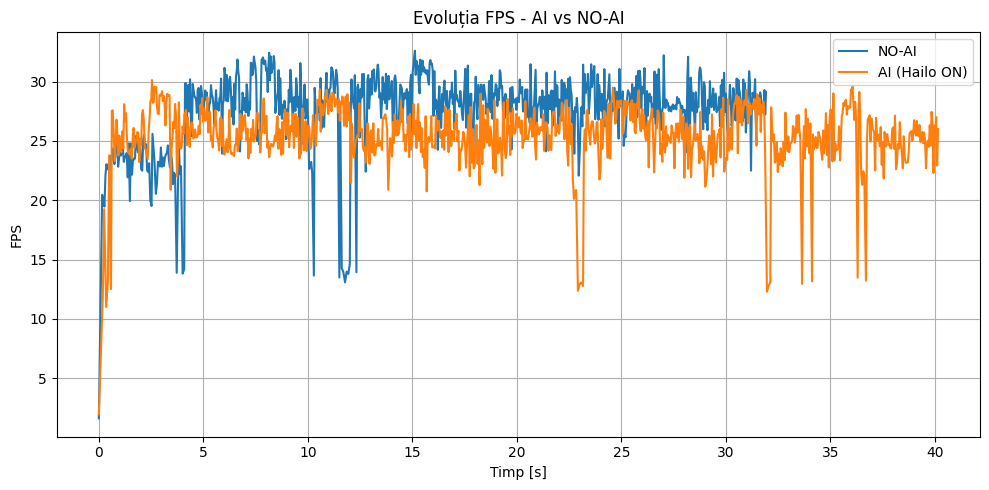

In [6]:
plt.figure()
plt.plot(df_noai["t_sec"], df_noai["fps"], label="NO-AI")
plt.plot(df_ai["t_sec"], df_ai["fps"], label="AI (Hailo ON)")
plt.xlabel("Timp [s]")
plt.ylabel("FPS")
plt.title("Evoluția FPS - AI vs NO-AI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("fps_ai_vs_noai.png", dpi=150)
plt.show()


Timp de procesare pe cadru (ms)

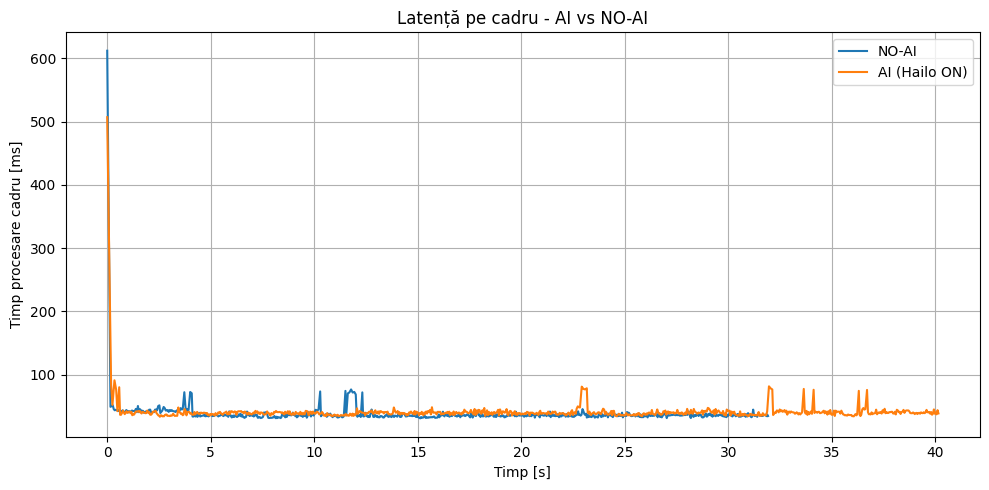

In [7]:
plt.figure()
plt.plot(df_noai["t_sec"], df_noai["frame_time_ms"], label="NO-AI")
plt.plot(df_ai["t_sec"], df_ai["frame_time_ms"], label="AI (Hailo ON)")
plt.xlabel("Timp [s]")
plt.ylabel("Timp procesare cadru [ms]")
plt.title("Latență pe cadru - AI vs NO-AI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("latency_ai_vs_noai.png", dpi=150)
plt.show()


Hailo score in timp (doar AI)

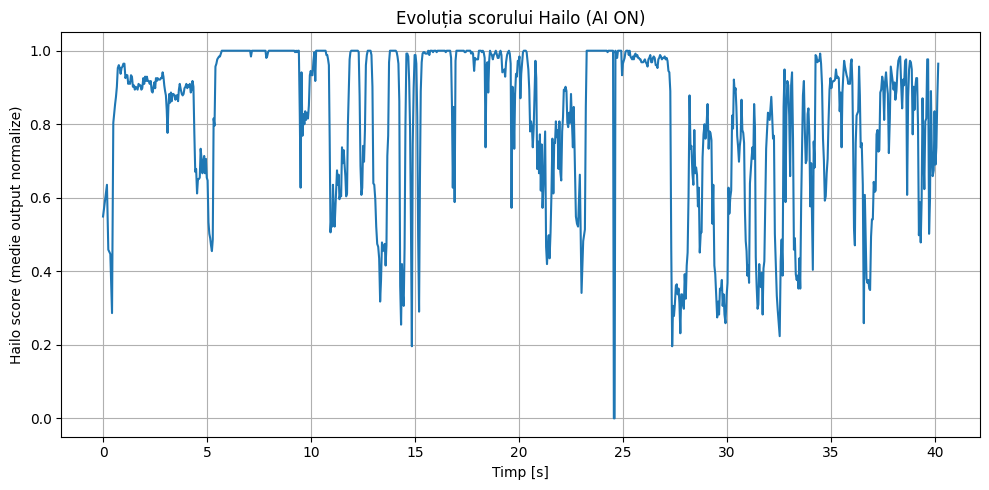

In [8]:
plt.figure()
plt.plot(df_ai["t_sec"], df_ai["hailo_score"])
plt.xlabel("Timp [s]")
plt.ylabel("Hailo score (medie output normalize)")
plt.title("Evoluția scorului Hailo (AI ON)")
plt.grid(True)
plt.tight_layout()
plt.savefig("hailo_score_over_time.png", dpi=150)
plt.show()


Distribuția comenzilor (bar chart comparativ)

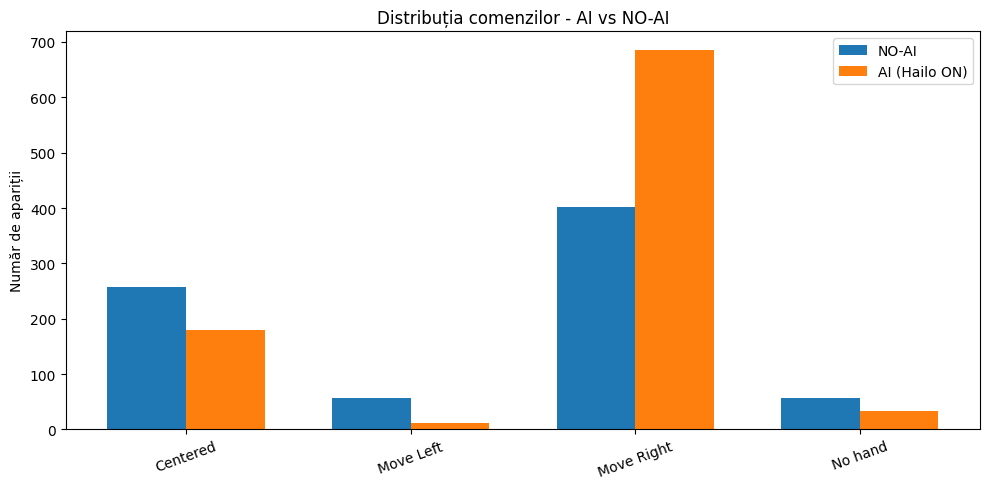

In [10]:
cmd_counts_noai = df_noai["command"].value_counts().sort_index()
cmd_counts_ai = df_ai["command"].value_counts().sort_index()

commands = sorted(set(cmd_counts_noai.index) | set(cmd_counts_ai.index))
vals_noai = [cmd_counts_noai.get(c, 0) for c in commands]
vals_ai = [cmd_counts_ai.get(c, 0) for c in commands]

x = np.arange(len(commands))
width = 0.35

plt.figure()
plt.bar(x - width/2, vals_noai, width, label="NO-AI")
plt.bar(x + width/2, vals_ai, width, label="AI (Hailo ON)")
plt.xticks(x, commands, rotation=20)
plt.ylabel("Număr de apariții")
plt.title("Distribuția comenzilor - AI vs NO-AI")
plt.legend()
plt.tight_layout()
plt.savefig("command_distribution_ai_vs_noai.png", dpi=150)
plt.show()


Procent "No hand"

In [11]:
def no_hand_ratio(df):
    return (df["command"] == "No hand").mean()

r_noai = no_hand_ratio(df_noai)
r_ai = no_hand_ratio(df_ai)

print(f"Procent 'No hand' (NO-AI): {r_noai:.3f}")
print(f"Procent 'No hand' (AI):    {r_ai:.3f}")


Procent 'No hand' (NO-AI): 0.073
Procent 'No hand' (AI):    0.036


Distribuția centroidului (cx, cy) în ROI

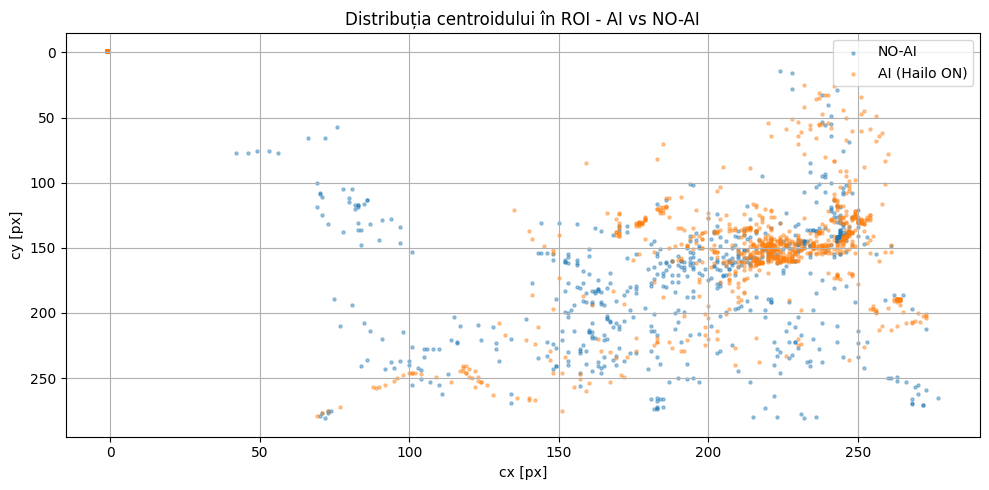

In [12]:
plt.figure()
plt.scatter(df_noai["cx"], df_noai["cy"], s=5, alpha=0.4, label="NO-AI")
plt.scatter(df_ai["cx"], df_ai["cy"], s=5, alpha=0.4, label="AI (Hailo ON)")
plt.gca().invert_yaxis()
plt.xlabel("cx [px]")
plt.ylabel("cy [px]")
plt.title("Distribuția centroidului în ROI - AI vs NO-AI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("centroid_ai_vs_noai.png", dpi=150)
plt.show()


Landmark-uri MediaPipe (medie)

In [13]:
print("Landmark-uri MediaPipe – medie pe cadru:")
print(f"NO-AI: {df_noai['mediapipe_landmarks'].mean():.2f}")
print(f"AI:    {df_ai['mediapipe_landmarks'].mean():.2f}")


Landmark-uri MediaPipe – medie pe cadru:
NO-AI: 18.47
AI:    20.42


Tabel sumar comparativ (metrice globale)

In [19]:

def compute_summary(df, label):
    return {
        "Scenario": label,
        "FPS mediu": df["fps"].mean(),
        "FPS minim": df["fps"].min(),
        "FPS maxim": df["fps"].max(),
        "Latență medie [ms]": df["frame_time_ms"].mean(),
        "Latență max [ms]": df["frame_time_ms"].max(),
        "Procent 'No hand'": (df["command"] == "No hand").mean(),
        "Media landmark-uri MediaPipe": df["mediapipe_landmarks"].mean(),
        "Comenzi trimise (tcp_sent)": df["tcp_sent"].sum(),
        "Reconectări TCP": df["tcp_reconnected"].sum(),
        "Hailo score mediu": df["hailo_score"].mean(),
        "Hailo valid ratio": df["hailo_valid"].mean()
    }

summary_rows = [
    compute_summary(df_noai, "NO-AI"),
    compute_summary(df_ai, "AI (Hailo ON)")
]

summary_df = pd.DataFrame(summary_rows)
summary_df_rounded = summary_df.copy()

for col in summary_df.columns:
    if summary_df[col].dtype == float:
        summary_df_rounded[col] = summary_df[col].round(3)

summary_df_rounded


,Scenario,FPS mediu,FPS minim,FPS maxim,Latență medie [ms],Latență max [ms],Procent 'No hand',Media landmark-uri MediaPipe,Comenzi trimise (tcp_sent),Reconectări TCP,Hailo score mediu,Hailo valid ratio
0,NO-AI,27.760,1.633,32.593,37.290,612.287,0.073,18.470,99,0,0.000,0.000
1,AI (Hailo ON),25.571,1.972,30.128,40.101,507.125,0.036,20.422,99,0,0.818,0.978


Export tabel sumar (CSV + Markdown)

In [30]:
summary_df_rounded.to_csv("summary_ai_vs_noai.csv", index=False)
summary_df_rounded.to_markdown("summary_ai_vs_noai.md", index=False)
summary_df_rounded



,Scenario,FPS mediu,FPS minim,FPS maxim,Latență medie [ms],Latență max [ms],Procent 'No hand',Media landmark-uri MediaPipe,Comenzi trimise (tcp_sent),Reconectări TCP,Hailo score mediu,Hailo valid ratio
0,NO-AI,27.760,1.633,32.593,37.290,612.287,0.073,18.470,99,0,0.000,0.000
1,AI (Hailo ON),25.571,1.972,30.128,40.101,507.125,0.036,20.422,99,0,0.818,0.978


Generator de text pentru concluzii

In [18]:
fps_noai = summary_df.loc[summary_df["Scenario"]=="NO-AI","FPS mediu"].iloc[0]
fps_ai   = summary_df.loc[summary_df["Scenario"]=="AI (Hailo ON)","FPS mediu"].iloc[0]

lat_noai = summary_df.loc[summary_df["Scenario"]=="NO-AI","Latență medie [ms]"].iloc[0]
lat_ai   = summary_df.loc[summary_df["Scenario"]=="AI (Hailo ON)","Latență medie [ms]"].iloc[0]

nohand_noai = summary_df.loc[summary_df["Scenario"]=="NO-AI","Procent 'No hand'"].iloc[0]
nohand_ai   = summary_df.loc[summary_df["Scenario"]=="AI (Hailo ON)","Procent 'No hand'"].iloc[0]

hailo_mean = summary_df.loc[summary_df["Scenario"]=="AI (Hailo ON)","Hailo score mediu"].iloc[0]

print("Rezumat (draft) pentru lucrare:\n")
print(f"- FPS mediu fără AI: {fps_noai:.2f}, cu AI: {fps_ai:.2f}.")
print(f"- Latența medie pe cadru (NO-AI vs AI): {lat_noai:.2f} ms vs {lat_ai:.2f} ms.")
print(f"- Procent de cadre etichetate 'No hand' (NO-AI vs AI): {nohand_noai:.3f} vs {nohand_ai:.3f}.")
print(f"- Scorul mediu Hailo pe toată sesiunea AI este {hailo_mean:.3f}, ceea ce reflectă activitatea modelului pe ROI.")


Rezumat (draft) pentru lucrare:

- FPS mediu fără AI: 27.76, cu AI: 25.57.
- Latența medie pe cadru (NO-AI vs AI): 37.29 ms vs 40.10 ms.
- Procent de cadre etichetate 'No hand' (NO-AI vs AI): 0.073 vs 0.036.
- Scorul mediu Hailo pe toată sesiunea AI este 0.818, ceea ce reflectă activitatea modelului pe ROI.
